In [13]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from utils import *

# torch._dynamo.config.suppress_errors = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load dataset:

In [4]:
data_size = 1_000_000
data_gen = SinglePixel(N=32)
X, true_y, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.3, features_degree=2, seed=42, device='cpu', test_return=True)
data_gen.noise_delta

{'mse_loss': {'mean': 0.008398772217333317, 'std': 0.02710288017988205},
 'l1_loss': {'mean': 0.04404409974813461, 'std': 0.08036725223064423}}

In [26]:
idx = 0
while true_y[idx][0] < 0.4:
    idx += 1

idx

7

Test generator:

In [84]:

class OnePixel(nn.Module):
    def __init__(self, *args, **kwargs):
        super(OnePixel, self).__init__()
        
        # self.conv_layers = blocks.BayesSequential(
        #     blocks.ConvNormAct(1, 2, 5, 2, 1, transpose=False),
        #     blocks.ConvNormAct(2, 4, 3, 2, 1, transpose=False),
        #     blocks.ConvNormAct(4, 8, 3, 2, 1, transpose=False),
        #     blocks.ConvNormAct(8, 16, 3, 2, 1, transpose=False)
        # )
        
        self.linear_1 = BayesLinear(36, 30)
        self.linear_2 = BayesLinear(30, 24)
        self.linear_3 = BayesLinear(24, 18)
        self.linear_4 = BayesLinear(18, 12)
        self.linear_5 = BayesLinear(12, 6)
        self.linear_6 = BayesLinear(6, 1)
        
    def forward(self, x):
        # z = self.conv_layers(true_target)

        kl_sum = 0
        x, kl = self.linear_1(x)
        kl_sum += kl
        x = torch.nn.functional.relu(x)
        x, kl = self.linear_2(x)
        kl_sum += kl
        x = torch.nn.functional.relu(x)
        x, kl = self.linear_3(x)
        kl_sum += kl
        x = torch.nn.functional.relu(x)
        x, kl = self.linear_4(x)
        kl_sum += kl
        x = torch.nn.functional.relu(x)
        x, kl = self.linear_5(x)
        kl_sum += kl
        x = torch.nn.functional.relu(x)
        x, kl = self.linear_6(x)
        kl_sum += kl
        
        return x, kl_sum


In [85]:
# load generator
generator = OnePixel()
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/SinglePixel/Adam_mse_loss_0/OnePixel_no_activation_function/OnePixel_no_activation_function_49.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print(f'Number of parameters: {count_params(generator):,}')

OnePixel(
  (linear_1): LinearReparameterization()
  (linear_2): LinearReparameterization()
  (linear_3): LinearReparameterization()
  (linear_4): LinearReparameterization()
  (linear_5): LinearReparameterization()
  (linear_6): LinearReparameterization()
)
Number of parameters: 5,234


In [86]:
n_samples = 10000

# getting the predictions for this feature
pred_pixels = torch.zeros((n_samples, 1), dtype=torch.float, device='cpu')
x = torch.Tensor(X[idx])
with torch.no_grad():
    for j in range(n_samples):
        pred_pixels[j] += generator(x)[0].squeeze()

pred_pixels = pred_pixels.detach().numpy()

In [87]:
n_samples = data_gen.kernel.shape[0] // 20

# getting the predictions for this feature
true_pixels = torch.zeros((n_samples, 1))
for j in range(n_samples):
    true_pixels[j] += true_y[idx] * data_gen.kernel[j]

true_pixels = true_pixels.numpy()

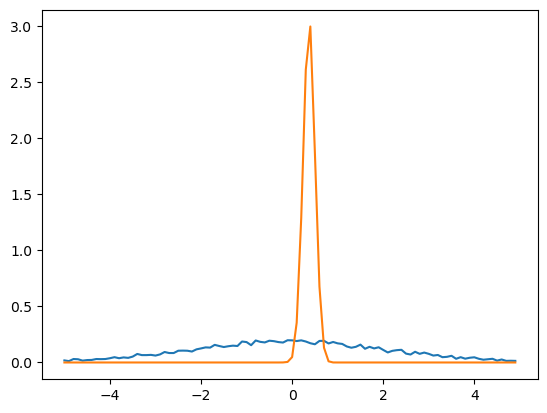

In [83]:
hist_width = 0.1

# predictited distribution
pred = pd.Series(pred_pixels.reshape(-1))
hist = pd.Series(1, index=pd.cut(pred, np.arange(-5, 5.005, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(-5, 5, hist_width), pred_noise)

# true distribution
true = pd.Series(true_pixels.reshape(-1))
true_hist = pd.Series(1, index=pd.cut(true, np.arange(-5, 5.005, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(-5, 5, hist_width), true_noise)
plt.show()

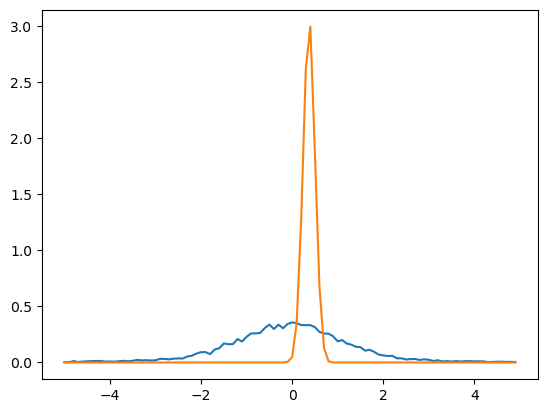

In [89]:
hist_width = 0.1

# predictited distribution
pred = pd.Series(pred_pixels.reshape(-1))
hist = pd.Series(1, index=pd.cut(pred, np.arange(-5, 5.005, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(-5, 5, hist_width), pred_noise)

# true distribution
true = pd.Series(true_pixels.reshape(-1))
true_hist = pd.Series(1, index=pd.cut(true, np.arange(-5, 5.005, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(-5, 5, hist_width), true_noise)
plt.show()

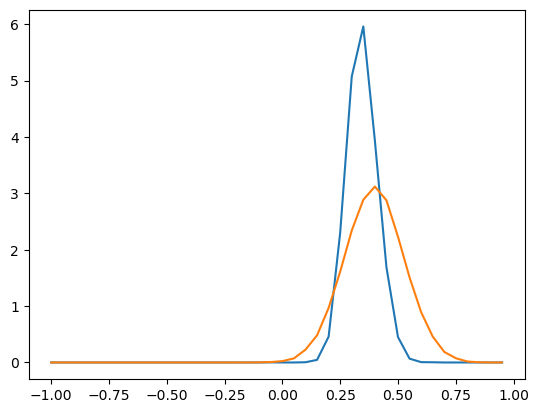

In [47]:
hist_width = 0.05

# predictited distribution
pred = pd.Series(pred_pixels.reshape(-1))
hist = pd.Series(1, index=pd.cut(pred, np.arange(-1, 1.005, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), pred_noise)

# true distribution
true = pd.Series(true_pixels.reshape(-1))
true_hist = pd.Series(1, index=pd.cut(true, np.arange(-1, 1.005, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), true_noise)
plt.show()

In [ ]:
hist_width = 0.05

# predictited distribution
pred = pd.Series(pred_pixels.reshape(-1))
hist = pd.Series(1, index=pd.cut(pred, np.arange(-1, 1.005, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), pred_noise)

# true distribution
true = pd.Series(true_pixels.reshape(-1))
true_hist = pd.Series(1, index=pd.cut(true, np.arange(-1, 1.005, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), true_noise)
plt.show()